In [1]:
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import _tree, plot_tree
import copy
import pandas as pd
from matplotlib import pyplot as plt
from util.dt import DT
from util.solver import DT_Solver
from pysmt.shortcuts import Symbol, And, Or, Iff, Not, Bool, Solver, Implies
from pysmt.oracles import get_logic
from collections import OrderedDict
from util.inference import *

In [2]:
data = load_iris() # load_breast_cancer() 
X = data['data']
y = data["target"]
y = y==1
feature_names = data["feature_names"]

In [3]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_test.shape, x_train.shape

((30, 4), (120, 4))

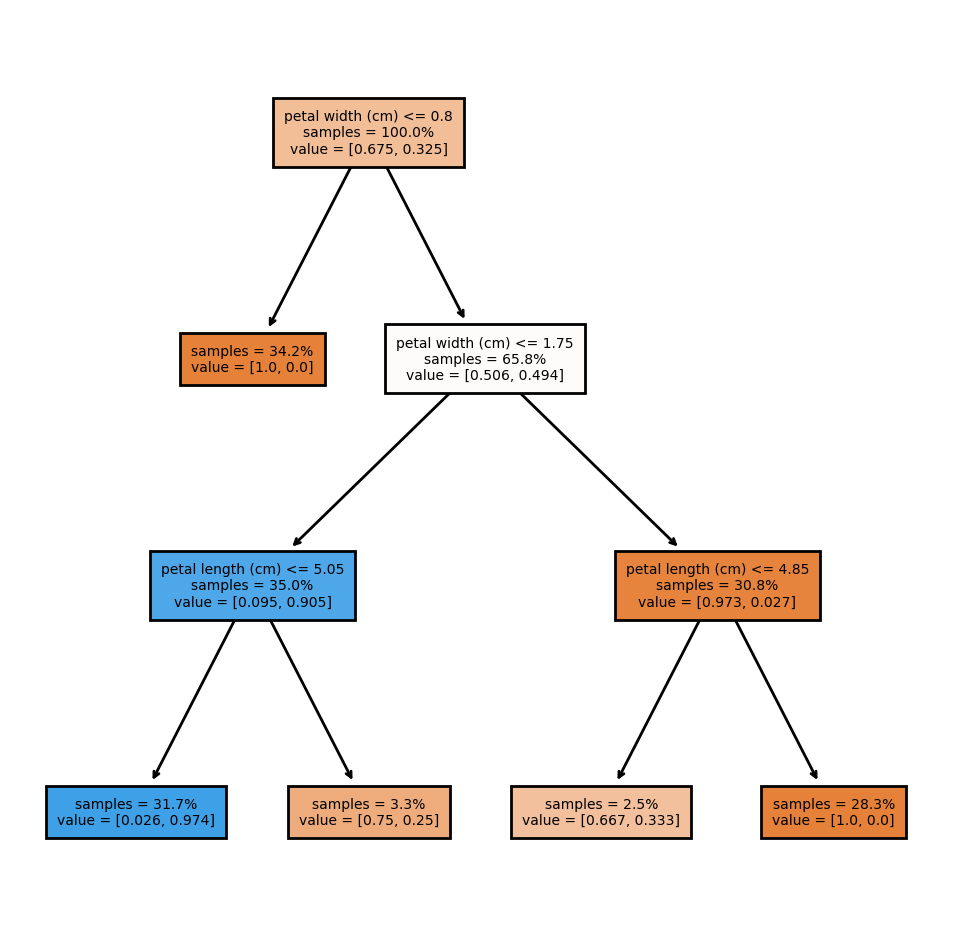

In [4]:
clf = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

plt.figure(figsize=(6,6), dpi=200)
_=plot_tree(clf, feature_names=feature_names, filled = True, fontsize=5, impurity=False, proportion=True)
plt.savefig("./trees/dt.png")

In [5]:
dict_thresh = get_thresholds(clf)
col_names = [f"{k}_{v[i]}"  for k, v in dict_thresh.items() for i in range(len(v))]
col_names

['3_0.800000011920929',
 '3_1.75',
 '2_4.8500001430511475',
 '2_5.049999952316284']

In [6]:
data_ = disc_data(x_train, dict_thresh)
data_.head()

,3_0.800000011920929,3_1.75,2_4.8500001430511475,2_5.049999952316284
0,False,False,False,False
1,False,False,False,False
2,True,True,True,False
3,True,True,False,False
4,True,True,True,True


In [7]:
col_names_str = [f"{feature_names[k]}_{v[i]}"  for k, v in dict_thresh.items() for i in range(len(v))]
data_f_ = disc_data(x_train, dict_thresh)
data_f_.columns = col_names_str
data_f_.head()

,petal width (cm)_0.800000011920929,petal width (cm)_1.75,petal length (cm)_4.8500001430511475,petal length (cm)_5.049999952316284
0,False,False,False,False
1,False,False,False,False
2,True,True,True,False
3,True,True,False,False
4,True,True,True,True


In [8]:
lineage = get_lineage(clf)
find_boundaries(clf)

{'2': {'3': [-inf, 0.800000011920929]},
 '6': {'2': [-inf, 5.049999952316284], '3': [0.800000011920929, 1.75]},
 '7': {'2': [5.049999952316284, inf], '3': [0.800000011920929, 1.75]},
 '8': {'2': [-inf, 4.8500001430511475], '3': [1.75, inf]},
 '9': {'2': [4.8500001430511475, inf], '3': [1.75, inf]}}

In [9]:
index = 10
sample = x_train[index:index+1]

leaves, min_corners, max_corners = leaf_boxes(clf.tree_)


logical_and = np.logical_and(
    np.all(min_corners[:, :, None] < sample.T[None, :, :], axis=1),
    np.all(max_corners[:, :, None] >= sample.T[None, :, :], axis=1)
).T.astype(int)[0]

print(logical_and)
min_corners.shape, sample.shape

[0 0 0 0 1]


((5, 4), (1, 4))

In [10]:
data_y = clf.predict(x_train)
data_x = data_.values

data_x.shape, data_y.shape

((120, 4), (120,))

In [11]:
tree_vars = create_tree_related(clf)
data_vars = create_fr_related(clf, np.asarray(data_.columns))
extra_cond = tree_vars.union(data_vars[0]).union(data_vars[1])
extra_cond

{'a(1,1)',
 'a(2,3)',
 'a(3,5)',
 'a(4,4)',
 'u(1,2)',
 'u(1,6)',
 'u(1,7)',
 'u(1,8)',
 'u(1,9)',
 'u(2,6)',
 'u(2,7)',
 'u(2,8)',
 'u(2,9)',
 'u(3,8)',
 'u(3,9)',
 'u(4,6)',
 'u(4,7)',
 (! 'a(1,2)'),
 (! 'a(1,6)'),
 (! 'a(1,7)'),
 (! 'a(1,8)'),
 (! 'a(1,9)'),
 (! 'a(2,6)'),
 (! 'a(2,7)'),
 (! 'a(2,8)'),
 (! 'a(2,9)'),
 (! 'a(3,8)'),
 (! 'a(3,9)'),
 (! 'a(4,6)'),
 (! 'a(4,7)'),
 ('c0(1)' <-> False),
 ('c0(2)' <-> True),
 ('c0(3)' <-> False),
 ('c0(4)' <-> False),
 ('c0(5)' <-> False),
 ('c0(6)' <-> False),
 ('c0(7)' <-> True),
 ('c0(8)' <-> True),
 ('c0(9)' <-> True),
 ('c1(1)' <-> False),
 ('c1(2)' <-> False),
 ('c1(3)' <-> False),
 ('c1(4)' <-> False),
 ('c1(5)' <-> False),
 ('c1(6)' <-> True),
 ('c1(7)' <-> False),
 ('c1(8)' <-> False),
 ('c1(9)' <-> False),
 ('l(1,1)' <-> False),
 ('l(1,2)' <-> True),
 ('l(1,3)' <-> False),
 ('l(1,4)' <-> False),
 ('l(1,5)' <-> False),
 ('l(1,6)' <-> False),
 ('l(1,7)' <-> False),
 ('l(1,8)' <-> False),
 ('l(1,9)' <-> False),
 ('l(2,1)' <-> False)

In [12]:
N_FEATURES = data_x.shape[1]
MAX_NODES = len(clf.tree_.feature) 

print("MAX_NODES: %d" % MAX_NODES)
print("N_FEATURES: %d" % N_FEATURES)

dt = DT(MAX_NODES, N_FEATURES)

solver = DT_Solver(MAX_NODES, N_FEATURES, (data_x, data_y), additional_const=extra_cond)
solver.init_solver()

solution, complete_solution = solver.solve_for_one(True)
dt.parse_solution(solution)
dt.draw(len(solution))

MAX_NODES: 9
N_FEATURES: 4
Target Logic: QF_BOOL


In [13]:
clf.predict(sample)

array([False])

In [14]:
inersect_inds = box_intersection(min_corners, sample * (0.7), max_corners, sample * (1.5))
ind_conversion = convert_tree_inds(clf)
inersect_boxes = np.asarray([str(int(ind_conversion[si])+1) for si in [str(li) for li in leaves]])[np.where(inersect_inds)[0]]

inersect_inds, leaves, [int(ind_conversion[str(i)])+1 for i in clf.apply(sample)], inersect_boxes

(array([[False],
        [ True],
        [ True],
        [ True],
        [ True]]),
 [1, 4, 5, 7, 8],
 [9],
 array(['6', '7', '8', '9'], dtype='<U1'))

In [15]:
formula, all_assignments = prediction_formula(complete_solution, [bool(xi) for xi in data_x[index]])
result = inference_sat(formula, all_assignments)
[c for c in result if 'ch' in str(c[0])], [c for c in result if 'f' in str(c[0])]

Target Logic: QF_BOOL


([('ch0(6)', False),
  ('ch1(7)', False),
  ('ch1(3)', False),
  ('ch0(9)', True),
  ('ch0(3)', False),
  ('ch0(1)', False),
  ('ch0(8)', False),
  ('ch1(2)', False),
  ('ch0(5)', False),
  ('ch1(5)', False),
  ('ch0(2)', False),
  ('ch1(4)', False),
  ('ch1(1)', False),
  ('ch1(9)', False),
  ('ch1(6)', False),
  ('ch1(8)', False),
  ('ch0(7)', False),
  ('ch0(4)', False)],
 [('f(2)', True), ('f(3)', True), ('f(1)', True), ('f(4)', True)])

In [16]:
if clf.predict(sample)[0]:
    formula, all_assignments = robustness_formula(complete_solution, ch0_vals=[int(si)-1 for si in inersect_boxes])
else:
    formula, all_assignments = robustness_formula(complete_solution, ch1_vals=[int(si)-1 for si in inersect_boxes])

result = inference_sat(formula, all_assignments)


[c for c in result if 'f' in str(c[0])], [c for c in result if 'ch' in str(c[0])]

Target Logic: QF_BOOL


([('f(2)', False), ('f(3)', False), ('f(1)', True), ('f(4)', False)],
 [('ch0(6)', False),
  ('ch1(7)', False),
  ('ch1(3)', False),
  ('ch0(9)', False),
  ('ch0(3)', False),
  ('ch0(1)', False),
  ('ch0(8)', False),
  ('ch1(2)', False),
  ('ch0(5)', False),
  ('ch1(5)', False),
  ('ch0(2)', False),
  ('ch1(4)', False),
  ('ch1(1)', False),
  ('ch1(9)', False),
  ('ch1(6)', True),
  ('ch1(8)', False),
  ('ch0(7)', False),
  ('ch0(4)', False)])